# Keras h5 to pb to tflite 

Here we Want to convert a keras model first into a pb file and then into a tflite file qith quantization.

Each step is marked and explained. Also which Version to use. 
- Step 1 Loading of the model can be done with any version 
    - (if `pip install git+https://github.com/rcmalli/keras-vggface.git` )
- Step 2 Saving the model as h5 needs 1.13.x, 
- Step 3 Transforming the h5 to pb or TF2 savedmodel is explained for both versions
- Step 4 Quantizing the model is also explained for both versions

We suggest to have two notebooks opened from different terminals with 1.13.x, 1.15 and 2.x versions.



# Quantization of tflite model

This notebook is quantizeing loaded model to int8 or int16. This is needed as the i.mx8MPlus utilize int8. 
From Marcus Levi:

*The NPU has several compute blocks, including Neural-Network Engine, Tensor Processor, and a processing/scheduler unit. The quantized models take advantage of the 2 former, whereas the FP(floating point) models run only the processing unit (like a manual process)*

FP32 models still run on the i.mx8MPlus, but the performance is just terrible. However, we are not sure which type of quantization is necessary.

- Dynamic range quantization
- Full integer quantization
- Float16 quantization 

In the official descirbtion : https://www.tensorflow.org/lite/performance/post_training_quantization 


The Full integer quantization is ment for CPU, Edge TPU, Microcontrollers. So Probably also for the i.mx8MPlus.

So we will start with the full interger quantization. 


Info from :
if you get following error: 
> AttributeError: module 'tensorflow._api.v1.lite' has no attribute 'Optimize'

this is due to TF version. in tf 1.13.x the Optimizer was not included. So use a later version

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
if tf.__version__.startswith('1.15'):
    # This prevents some errors that otherwise occur when converting the model with TF 1.15...
    tf.enable_eager_execution() # Only if TF is version 1.15

1.15.3


In [1]:
import keras
from keras_vggface.vggface import VGGFace
import tensorflow as tf
print(tf.version.VERSION)

import os


1.15.3


Using TensorFlow backend.


## Step 1 loading the model

In [2]:
from keras_vggface.vggface import VGGFace

pretrained_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')  # pooling: None, avg or max
pretrained_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__

## Step 2 save the keras model with save as h5

This only works with version 1.13.1 or 1.13.2  
Otherwise : ValueError: Tensor name 'batch_normalization/cond/ReadVariableOp/Switch:1' is invalid.

Look here:  
https://github.com/tensorflow/tensorflow/issues/31331  
If you have to work with 1.14.x there is a workaround in the comments by setting:   

`K.set_learning_phase(0)`




In [4]:
pretrained_model.save("my_model_int8.h5") #using h5 extension
os.getcwd()

'/home/base/Documents/Git/Projekte/CelebFaceMatcher'

## check the model by loading and plotting

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

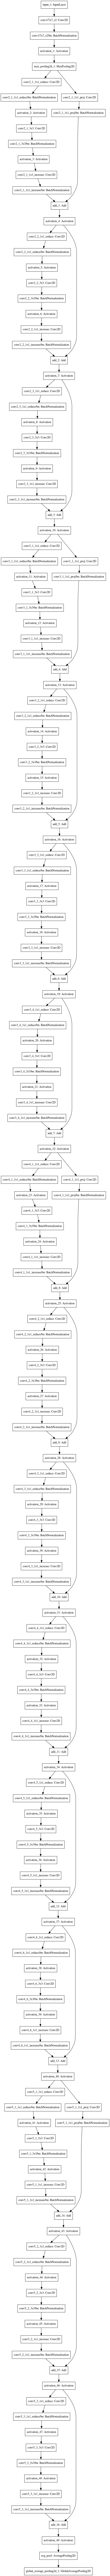

In [3]:
import keras
import tensorflow as tf
h5_path = 'my_model.h5'
model = keras.models.load_model(h5_path)
model.summary()
tf.keras.utils.plot_model(
    model,
    #to_file="model.png", # if you want to have it also as a file
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


## Step 3 transforming the h5 file to pb

### TF < 2.x

#### Use this with Tensorflow < 2.x, Otherwise use next step, which performes the same

--

This does not work with TF => 2.0 as freezing graphs is not supported anymore. Hohwever, you can make it work by adding:  
`tf.compat.v1.disable_eager_execution()`


But for TF 2.x better look one below. By just using 
   `model.save` 
Later, converting to tflite, using saved_model will also ask only for a dir. This makes sense as the model.save of TF 2.x creates a folder.

If you use TF>2.0
You have to use tf.compat.v1.disable_eager_execution(), which is not neccecary with tf<2.0  
you run into following error:  

> RuntimeError: Attempted to use a closed Session.  

This can be solved by restartingthe kernel. 

If you run into:  
> AssertionError: global_average_pooling2d_1_1/Identity is not in graph 

This is due to using TF2.x and not having *tf.compat.v1.disable_eager_execution()*
in use

To think about:
The pb files of TF1.x and TF2.x are different follow this [thread]. So saving the h5 to pb with TF" could lead to problems as it is actually a TF1 function until here.   
tf.GraphDef() is not available in tf 2.0. In tf 2.0, graph/session concept has changed. Please try to use savedmodel api and do not use session, etc

[thread]:https://github.com/tensorflow/models/issues/7508

In [ ]:
import logging
import tensorflow as tf
from tensorflow.compat.v1 import graph_util
from tensorflow.python.keras import backend as K
from tensorflow import keras
import os

# necessary for TF2.x!!!
#tf.compat.v1.disable_eager_execution()

h5_path = 'my_model.h5'
model = keras.models.load_model(h5_path)
model.summary()
# save pb
with K.get_session() as sess:
    output_names = [out.op.name for out in model.outputs]
    input_graph_def = sess.graph.as_graph_def()
    for node in input_graph_def.node:
        node.device = ""
    graph = graph_util.remove_training_nodes(input_graph_def)
    graph_frozen = graph_util.convert_variables_to_constants(sess, graph, output_names)
    tf.io.write_graph(graph_frozen,os.getcwd(),'my_model1.13.pb', as_text=False)
logging.info("save pb successfully！")
print("save pb successfully！")

In [3]:
import os
print(os.getcwd())

/home/base/Documents/Git/Projekte/CelebFaceMatcher


## Step 3 converting h5 to TF2 model

### TF = 2.x

In [ ]:
import logging
import tensorflow as tf
from tensorflow.compat.v1 import graph_util
from tensorflow.python.keras import backend as K
from tensorflow import keras
import os

# necessary for TF2.x!!!
#tf.compat.v1.disable_eager_execution()

h5_path = 'my_model.h5'
model = keras.models.load_model(h5_path)

model.save(os.getcwd() +'/modelTF2') 

## Step 4 Quantize the model 
### In TF >= 2.0 Use the following

**Important** read [understanding-tf-contrib-lite-tfliteconverter-quantization-parameters](https://stackoverflow.com/questions/54830869/understanding-tf-contrib-lite-tfliteconverter-quantization-parameters), what is the differnece of postraining_quantizaition and fullin8 conversion

If you use a TF 2.x version, the from _saved_model should be used. 

--------------------------------------------------  
If we use  *from_saved_model*, the function takes only a dir, therfore the model name must be:  
*saved_model.pbtxt*   
or   
*saved_model.pb*  

--------------------------------------------------

If you receive error:
> tf.lite.TFLiteConverter.from_keras_model giving 'str' object has no attribute 'call'

this is due to maybe not supported model??
check [here](https://github.com/tensorflow/tensorflow/issues/32693)

It seems that from TF 2.0 tflite models can only take floats, and convert them to uint8s [internally](https://github.com/google-coral/edgetpu/issues/13#issuecomment-543758317)

To use TF 2.x like TF 1.15 you can add `tf.compat.v1.lite.TFLiteConverter.from_keras_model_file()` This will reslove that issue, but just works as TF1.x. Apparently TF2.0 cannot use Keras models ,only tf.keras models. 

In [ ]:
import tensorflow as tf
import cv2
from keras_vggface.utils import preprocess_input


#------------------------!!--------------------------
# IF WE USE THE PB FILE AND from_saved_model THAN THE MODEL NAME MUST BE: saved_model.pbtxt or saved_model.pb
# from_saved_model TAKES ONLY A DIR
#--------------------------------------------------
fullint=True

saved_model_dir='/home/base/Documents/Git/Projekte/CelebFaceMatcher/modelTF2'
num_calibration_steps=5
#converter= tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.experimental_new_converter = True
#converter.post_training_quantize = True  # This only makes the weight in8 but does not initialize model quantization   
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    pfad='/home/base/Documents/Git/Projekte/CelebFaceMatcher/All_croped_images/Aaron Paul/000001.jpg'
    Beleb=cv2.imread(pfad)
    pixels = Beleb.astype('float32')
    samples = expand_dims(pixels, axis=0)
    samples = preprocess_input(samples, version=2)    
    # Get sample input data as a numpy array in a method of your choosing.
    yield [sample]
converter.representative_dataset = representative_dataset_gen
if fullint:
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    #converter.inference_input_type = tf.float32
    #converter.inference_output_type = tf.float32
    
    #from https://github.com/mattroos/EdgeTpuTesting/blob/master/test_edgetpu.ipynb
    # Tensorflow TPU team uses type of tf.lite.constants.QUANTIZED_UINT8
    #   https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/export_model.py
    #converter.inference_input_type = tf.lite.constants.QUANTIZED_UINT8
    #converter.inference_output_type = tf.lite.constants.QUANTIZED_UINT8
tflite_quant_model = converter.convert()
open(os.getcwd() +"/quantized_modelTF2.tflite", "wb").write(tflite_quant_model)
print('model quantized')

## Step 4 Quantize the model 

### In TF < 2.0 use the following
Use here TF1.13  for 1.15.3 look below

TF lite < 1.15.0 does not have the function Optimize. 
Solution could be found here: https://github.com/tensorflow/tensorflow/issues/26413  
Does not work with TF > 2.x

check out  
[post-training-full-integer-quantization-of-keras-model](https://stackoverflow.com/questions/58623192/post-training-full-integer-quantization-of-keras-model/58666509#58666509) and   
[convert-keras-model-to-quantized-tensorflow-lite-model-that-can-be-used-on-edge](https://stackoverflow.com/questions/58123573/convert-keras-model-to-quantized-tensorflow-lite-model-that-can-be-used-on-edge) and   
[how-to-quantize-inputs-and-outputs-of-optimized-tflite-model](https://stackoverflow.com/questions/56856262/how-to-quantize-inputs-and-outputs-of-optimized-tflite-model)

there was an attempt to use a pb file transformed with TF<2.x using sessions (see above). This leads also to a pb file, but using the from_saved_model, which looks for a pb file, results in an error:
> RuntimeError: MetaGraphDef associated with tags {'serve'} could not be found in SavedModel. To inspect available tag-sets in the SavedModel, please use the SavedModel CLI: `saved_model_cli`

as the pb model saved by TF 2.x with `savemodel()` creates a folder which inherits all information needed. 
So here, with TF >2.x we can only use `from_keras_model` 



It does not matter if the pb file was created using sessions with 1.13 or 2.2.0 (+`tf.compat.v1.disable_eager_execution()`) It does not matter. 

In TF 2.x it is the function: `from_keras_model`  
In TF 1.x it is the function: `from_keras_model_file`

for `num_calibration_steps` see here:
https://stackoverflow.com/questions/58123573/convert-keras-model-to-quantized-tensorflow-lite-model-that-can-be-used-on-edge


In [ ]:
import tensorflow as tf
from keras_vggface.utils import preprocess_input
import cv2

#------------------------!!--------------------------
# IF WE USE THE PB FILE AND from_saved_model THAN THE MODEL NAME MUST BE: saved_model.pbtxt or saved_model.pb
# from_saved_model TAKES ONLY A DIR. 
# So give the dir name and place a saved_model.pb into that folder
#--------------------------------------------------

saved_model_dir='/home/base/Documents/Git/Projekte/CelebFaceMatcher/compare the models delete/'

modeA='PB_model'
modeB='keras_model'
Modus=modeB
print(tf.version.VERSION)

num_calibration_steps=5
if Modus=='PB_model':
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
elif Modus=='keras_model':  
    modelo='my_model.h5'
    if tf.__version__.startswith('2.'):
        converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(saved_model_dir + modelo) #works now also with TF2.x
        #converter = tf.lite.TFLiteConverter.from_keras_model(saved_model_dir + modelo) # Works only with TF1.x       
    if tf.__version__.startswith('1.'):
        converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_model_dir + modelo)        
        
# added code to convert model to a quantized tflite format.
#converter.post_training_quantize = True  # This only makes the weight in8 but does not initialize model quantization  
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    pfad='/home/base/Documents/Git/Projekte/CelebFaceMatTestcher/All_croped_images/Aaron Paul/000001.jpg'
    Beleb=cv2.imread(pfad)
    pixels = Beleb.astype('float32')
    samples = expand_dims(pixels, axis=0)
    samples = preprocess_input(samples, version=2)
    # Get sample input data as a numpy array in a method of your choosing.
    yield [samples]
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()
open("quantized_modelpb13-13.tflite", "wb").write(tflite_quant_model)
if Modus==modeA:
    print('1.13.x PB model quantized ')
if Modus==modeB:
    print('1.13.x Keras model quantized ')    

## Quantization with 1.15.x

to see if we can also get full int8 quantization with 1.x

use here TF 1.15.0

**Seems to work with 1.15.3**


In [1]:
import tensorflow as tf
print(tf.version.VERSION)
if tf.__version__.startswith('1.15'):
    # This prevents some errors that otherwise occur when converting the model with TF 1.15...
    tf.enable_eager_execution() # Only if TF is version 1.15

1.15.3


In [3]:
import tensorflow as tf
import cv2
from keras_vggface.utils import preprocess_input
import numpy as np

fullint=True


saved_model_dir='/home/base/Documents/Git/Projekte/CelebFaceMatcher/compare the models delete/'
modelo='my_model.h5'

modeA='PB_model'
modeB='keras_model'
Modus=modeB
Datentyp='uint8'   #'int8' or 'uint8'


print(tf.version.VERSION)

num_calibration_steps=5
if Modus=='PB_model':
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
elif Modus=='keras_model':  
    modelo='my_model.h5'
    if tf.__version__.startswith('2.'):
        converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(saved_model_dir + modelo) #works now also with TF2.x
        #converter = tf.lite.TFLiteConverter.from_keras_model(saved_model_dir + modelo) # Works only with TF1.x       
    if tf.__version__.startswith('1.'):
        converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_model_dir + modelo)  
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  for _ in range(100):
    pfad='/home/base/Documents/Git/Projekte/CelebFaceMatcher/All_croped_images/Aaron Paul/000001.jpg'
    Beleb=cv2.imread(pfad)
    pixels = Beleb.astype('float32')/255#!!!!! This is wrong as there is no normalization. use tf.convert_image_dtype
    samples = np.expand_dims(pixels, axis=0)
    samples = preprocess_input(samples, version=2) 
    samples = samples.astype(Datentyp)#!!!!! This is wrong as there is no normalization. use tf.convert_image_dtype
    # Get sample input data as a numpy array in a method of your choosing.
    yield [samples]
converter.representative_dataset = representative_dataset_gen
if fullint:
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    if Datentyp=='int8':
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
    if Datentyp=='uint8':    
        converter.inference_input_type = tf.uint8  
        converter.inference_output_type = tf.uint8  
    else:
        print('check your datatype.Should be int8 or uint8')
        
tflite_quant_model = converter.convert()
print('1.x Keras model quantized ')
open("quantized_modelh5-15_we_unit8", "wb").write(tflite_quant_model)


Using TensorFlow backend.


1.15.3


ValueError: Cannot set tensor: Got tensor of type UINT8 but expected type FLOAT32 for input 1, name: input_1 

In [1]:
import tensorflow as tf
import cv2
from keras_vggface.utils import preprocess_input
import numpy as np

fullint=True


saved_model_dir='/home/base/Documents/Git/Projekte/CelebFaceMatcher/compare the models delete/'
modelo='my_model.h5'

modeA='PB_model'
modeB='keras_model'
Modus=modeB
Datentyp='int8'   #'int8' or 'uint8'

print(tf.version.VERSION)

if Modus=='PB_model':
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
elif Modus=='keras_model':  
    modelo='my_model.h5'
    if tf.__version__.startswith('2.'):
        converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(saved_model_dir + modelo) #works now also with TF2.x
        #converter = tf.lite.TFLiteConverter.from_keras_model(saved_model_dir + modelo) # Works only with TF1.x       
    if tf.__version__.startswith('1.'):
        converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_model_dir + modelo)  
        
def representative_dataset_gen():
  for _ in range(10):
    pfad='/home/base/Documents/Git/Projekte/CelebFaceMatcher/All_croped_images/Aaron Paul/000001.jpg'
    img=cv2.imread(pfad)
    img = np.expand_dims(img,0).astype(np.float32) 
    #pixels = samples.astype('float32')#!!!!! This is wrong as there is no normalization. use tf.convert_image_dtype
    #samples = np.expand_dims(pixels, axis=0)
    #samples = preprocess_input(samples, version=2) 
    #samples = samples.astype(Datentyp)#!!!!! This is wrong as there is no normalization. use tf.convert_image_dtype
    # Get sample input data as a numpy array in a method of your choosing.
    yield [img]
    
converter.representative_dataset = representative_dataset_gen

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.experimental_new_converter = True

converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8 # or tf.uint8
converter.inference_output_type = tf.int8 # or tf.uint8
quantized_tflite_model = converter.convert()
if tf.__version__.startswith('1.'):
    open("tf1_15_3_all_int8.tflite", "wb").write(quantized_tflite_model)
if tf.__version__.startswith('2.'):
    with open("tf220_all_int8.tflite", 'wb') as f:
        f.write(quantized_tflite_model)# mit 220 vs 2_2_0 Ich hatte im modelcode dtype int32 und int8 eingefüght. Jetzt wieder draußen

Using TensorFlow backend.


2.2.0
